In [147]:
import pandas as pd
import MySQLdb
import jaro
from Levenshtein import distance,jaro_winkler
import distance
from gensim.models.word2vec import Word2Vec

In [13]:
mysql_cn= MySQLdb.connect(host='127.0.0.1', 
                port=8889,user='root', passwd='dmkm1234', 
                db='dmkm_articles')
sig = pd.read_sql('select * from dmkm_articles.signature1;', con=mysql_cn)    
print 'loaded dataframe from MySQL. records:', len(df_mysql)
mysql_cn.close()

loaded dataframe from MySQL. records: 1433


In [86]:
sig['key'] = 0
df_cartesian = sig.join(sig, how='left', on = 'key',lsuffix='_x', rsuffix='_y')
df_cartesian = df_cartesian.drop('key', 1)

In [89]:
print df_cartesian.columns
print df_cartesian.shape

Index([u'id_x', u'd_x', u'author_x', u'title_x', u'journal_x', u'year_x', u'keyword_x', u'institution_x', u'author_process_x', u'coauthor_x', u'first_name_x', u'initial_x', u'phonetic_x', u'id1GT_x', u'authorFullGT_x', u'sigID_x', u'key_x', u'id_y', u'd_y', u'author_y', u'title_y', u'journal_y', u'year_y', u'keyword_y', u'institution_y', u'author_process_y', u'coauthor_y', u'first_name_y', u'initial_y', u'phonetic_y', u'id1GT_y', u'authorFullGT_y', u'sigID_y', u'key_y'], dtype='object')
(2053489, 34)


In [90]:
df_cartesian = df_cartesian[df_cartesian.id_x != df_cartesian.id_y]
df_cartesian = df_cartesian[df_cartesian.phonetic_x == df_cartesian.phonetic_y]

In [152]:
word2vec = Word2Vec.load('name2vec1')

In [91]:
datafeatures = pd.DataFrame()

In [116]:
def compare(x,y):
    if x ==y:
        return 1
    else:
        return 0

In [128]:
# Author Name (jaro winkler)
datafeatures['author_name'] = df_cartesian[['author_process_x','author_process_y']].apply(lambda x : 
                                                             jaro_winkler(x['author_process_x'],x['author_process_y'])
                                                             ,axis=1)

In [131]:
# Initials (Levenshtein)
datafeatures['initials'] = df_cartesian[['title_x','title_y']].apply(lambda x : 
                                                             distance(x['title_x'],x['title_y'])
                                                             ,axis=1)

In [127]:
# Absolute Year (Absolute Difference)
datafeatures['year'] = df_cartesian[['year_x','year_y']].apply(lambda x : (x['year_x']-x['year_y']),axis=1)

In [155]:
# Author2Vec
datafeatures['author2vec'] = df_cartesian[['author_x','author_y']].apply(lambda x : 
                                                             word2vec.similarity(x['author_x'],x['author_y'])
                                                             ,axis=1)

In [119]:
# Class
datafeatures['class'] = df_cartesian[['id1GT_x','id1GT_y']].apply(lambda x : compare(x['id1GT_x'],x['id1GT_y']),axis =1)

In [156]:
datafeatures.head()

,author_name,class,year,initials,author2vec
0,1.000000,1,0,0,1.000000
0,0.980952,0,0,1,0.736619
0,1.000000,1,2,0,1.000000
0,0.980952,0,2,1,0.736619
0,1.000000,1,2,0,1.000000


In [157]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

In [158]:
%matplotlib inline

In [159]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

In [163]:
X = datafeatures[['author_name','year','initials','author2vec']]
y = datafeatures[['class']]

In [164]:
forest.fit(X, y)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [172]:
X.columns

Index([u'author_name', u'year', u'initials', u'author2vec'], dtype='object')

In [170]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print indices

[2 0 3 1]


Feature ranking:
1. feature 2 (0.595610)
2. feature 0 (0.287541)
3. feature 3 (0.114459)
4. feature 1 (0.002391)


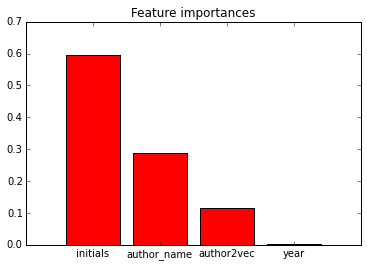

In [191]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), ['initials','author_name','author2vec','year'])
plt.xlim([-1, X.shape[1]])
plt.ylim([0,.7])
plt.savefig('word2vec.pdf')
plt.show()
